In [1]:
import numpy as np 
import torch
from torchsummary import summary
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [2]:
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as datatools

class LSTM_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=128, num_layers=2, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(128, 2)
    def forward(self, x):
        x, _ = self.lstm(x)
        # take only the last output
        x = x[:, -1, :]
        # produce output
        x = self.linear(self.dropout(x))
        return x 

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False 

def plot_training(losses):
    fig, axes = plt.subplots(1,len(losses), sharex=False, sharey=False)
    for i , (key, value) in enumerate(losses.items()):
        x_points = range(0, len(value))
        axes[i].set_title(key, fontsize=10)
        axes[i].plot(x_points, value, color="blue", linewidth=5)
        axes[i].yaxis.grid(True, zorder=0)
        axes[i].set_xlabel('Iteration', fontsize=10)
        # axes[i].legend(loc='upper right')
    # plt.tight_layout()
    plt.show()
    
def train(lstm_model, loader_train, loader_test, n_epochs, early_stopper, device):
    best_model = None
    best_loss = np.inf
    loss_train = []
    loss_validation = []
    for epoch in range(n_epochs):
        lstm_model.train()
        loss_tr =0
        for X_batch, y_batch in loader_train:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = lstm_model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_tr += loss.item()
        loss_train.append(loss_tr)
        print('Epoch %s/%s: Train Cross-Entropy: %.6f' % (epoch+1,n_epochs, loss_tr/len(loader_train)))
            
        # Validation
        lstm_model.eval()
        loss= 0
        with torch.no_grad():
            for X_batch_test, y_batch_test in loader_test:
                X_batch_test = X_batch_test.to(device)
                y_batch_test = y_batch_test.to(device)
                y_pred_test = lstm_model(X_batch_test)
                loss += loss_fn(y_pred_test, y_batch_test)
                # print( loss)
                # loss_te += loss
            loss_validation.append(loss.item())
            # if loss < best_loss:
            #     best_loss = loss
            #     best_model = lstm_model.state_dict()
            
            print("Epoch %s/%s: Validation Cross-Entropy: %.6f" % (epoch+1,n_epochs, loss.item()/len(loader_test)))
            if early_stopper.early_stop(loss.item()): 
                best_model = lstm_model.state_dict()            
                break 
    losses = {"train": loss_train, "validation": loss_validation}
    plot_training(losses)
    return best_model, lstm_model, loss_train, loss_validation 

def create_sequences(data, seq_length):
    xs = []
    ys = []
    for series in data:
        for i in range(data.shape[1]-seq_length-1):
            x = series[i:(i+seq_length)]
            if series[i+seq_length] > series[i+seq_length-1]:
                y = 1
            else:
                y = 0
            xs.append(x)
            ys.append(y)
    xs = np.array(xs)
    ys = np.array(ys)
    xs = torch.tensor(xs, dtype=torch.float32).reshape(-1, seq_length, 1)
    ys = torch.tensor(ys)
    return xs, ys

In [3]:
device = 'cpu'
gen_dir = 'generated_data/'
models_dir = 'models/' 
results_dir = 'results/'

In [4]:
# Load data
data = np.load('master_data/data.npy')
train_batches = data.shape[0] # N hereafter. Number of training images in database.
length = data.shape[1] 
stocks = data.shape[2]
print('Number of training batches: ', train_batches)
print('Length of each batch: ', length)
print('Number of stocks: ', stocks)

Number of training batches:  79
Length of each batch:  256
Number of stocks:  434


In [5]:
vaeconv1 = np.load(gen_dir + 'vaeconv1.npy')
vaeconv3 = np.load(gen_dir + 'vaeconv3.npy')
vaefd1 = np.load(gen_dir + 'vaefd1.npy')
vaefd2 = np.load(gen_dir + 'vaefd2.npy')
vqvaeconv2 = np.load(gen_dir + 'vqvaeconv2.npy')
vqvaefd1 = np.load(gen_dir + 'vqvaefd1.npy')
timevaebase = np.load(gen_dir + 'timevaebase.npy')

In [6]:
# Random batche
# index = np.random.randint(0, train_batches, 1)
index = 66
batch = data[index,:,:]
batch = np.transpose(batch)
batch = np.squeeze(batch)
batch.shape

(434, 256)

In [7]:
generated = {
   'TIME VAE BASE':timevaebase,
   'VAE CONV1 ':vaeconv1,
   'VAE CONV3':vaeconv3,
   'VAE FD1':vaefd1,
   'VAE FD2':vaefd2,
   'VQ VAE CONV2':vqvaeconv2,
   'VQ VAE FD1':vqvaefd1}

In [8]:

seq_length = 30
n_train = int(.5*length)
n_test = int(.8*length)

real_data = {'Trainig': batch[:,0:n_train], 
            'Validation': batch[:,n_train:n_test], 
            'Test': batch[:,n_test:]}

real_data_sq = {}

for key, value in real_data.items():
    x, y = create_sequences(value, seq_length)
    real_data_sq[key] = {'X': x, 'y': y}



In [9]:
x_train = real_data_sq['Trainig']['X']
x_val = real_data_sq['Validation']['X']
x_test = real_data_sq['Test']['X']
print('x_train shape: ', x_train.shape)
print('x_val shape: ', x_val.shape)
print('x_test shape: ', x_test.shape)

x_train shape:  torch.Size([42098, 30, 1])
x_val shape:  torch.Size([19530, 30, 1])
x_test shape:  torch.Size([9114, 30, 1])


In [15]:
print('Train \% of 1: ', real_data_sq['Trainig']['y'].count_nonzero()/len(real_data_sq['Trainig']['y']))
print('Val \% of 1: ', real_data_sq['Validation']['y'].count_nonzero()/len(real_data_sq['Validation']['y']))
print('Test \% of 1: ', real_data_sq['Test']['y'].count_nonzero()/len(real_data_sq['Test']['y']))

Train \% of 1:  tensor(0.4989)
Val \% of 1:  tensor(0.4833)
Test \% of 1:  tensor(0.4888)


# Train on Real data

Epoch 1/100: Train Cross-Entropy: 88.716044
Epoch 1/100: Validation Cross-Entropy: 88.470256
Epoch 2/100: Train Cross-Entropy: 88.682490
Epoch 2/100: Validation Cross-Entropy: 88.534461
Epoch 3/100: Train Cross-Entropy: 88.674663
Epoch 3/100: Validation Cross-Entropy: 88.410731
Epoch 4/100: Train Cross-Entropy: 88.622562
Epoch 4/100: Validation Cross-Entropy: 88.254442
Epoch 5/100: Train Cross-Entropy: 88.488254
Epoch 5/100: Validation Cross-Entropy: 88.004762
Epoch 6/100: Train Cross-Entropy: 87.066864
Epoch 6/100: Validation Cross-Entropy: 85.671294
Epoch 7/100: Train Cross-Entropy: 84.516600
Epoch 7/100: Validation Cross-Entropy: 81.681826
Epoch 8/100: Train Cross-Entropy: 81.577292
Epoch 8/100: Validation Cross-Entropy: 77.818487
Epoch 9/100: Train Cross-Entropy: 78.261919
Epoch 9/100: Validation Cross-Entropy: 74.806819
Epoch 10/100: Train Cross-Entropy: 75.104349
Epoch 10/100: Validation Cross-Entropy: 72.167388
Epoch 11/100: Train Cross-Entropy: 72.371600
Epoch 11/100: Validatio

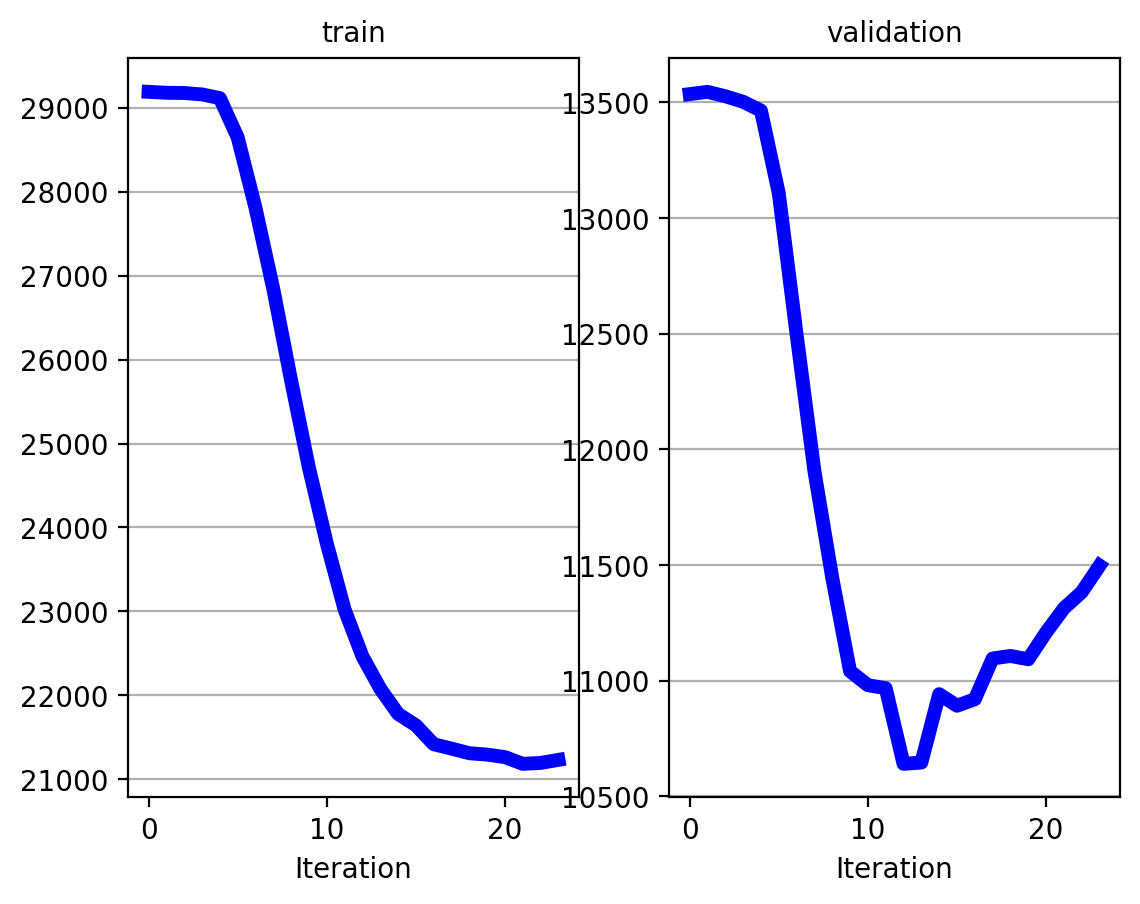

In [11]:
x_train = real_data_sq['Trainig']['X']
y_train = real_data_sq['Trainig']['y']
x_val = real_data_sq['Validation']['X']
y_val = real_data_sq['Validation']['y']

device = 'mps'
n_epochs = 100
batch_size = 128
learning_rate = 0.0001
lstm_model = LSTM_Model().to(device)
early_stopper = EarlyStopper(patience=10, min_delta=10)
optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(reduction="sum")
loader_train = datatools.DataLoader(datatools.TensorDataset(x_train, y_train ), shuffle=True, batch_size=batch_size)
loader_test = datatools.DataLoader(datatools.TensorDataset(x_val, y_val), shuffle=False, batch_size=batch_size)
best_model, real_lstm_model, loss_train, loss_validation = train(lstm_model, loader_train, loader_test, n_epochs, early_stopper, device)
torch.save(best_model, models_dir+"best_real_lstm.pth")

In [13]:
test_model = LSTM_Model().to(device)
test_model.load_state_dict(torch.load(models_dir+"best_real_lstm.pth"))
test_model

LSTM_Model(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=128, out_features=2, bias=True)
)

# Train on Synthetic data

Training model:  TIME VAE BASE
Epoch 1/200: Train Cross-Entropy: 88.699901
Epoch 1/200: Validation Cross-Entropy: 88.471552
Epoch 2/200: Train Cross-Entropy: 88.698987
Epoch 2/200: Validation Cross-Entropy: 88.471941
Epoch 3/200: Train Cross-Entropy: 88.687905
Epoch 3/200: Validation Cross-Entropy: 88.491179
Epoch 4/200: Train Cross-Entropy: 88.686332
Epoch 4/200: Validation Cross-Entropy: 88.471009
Epoch 5/200: Train Cross-Entropy: 88.664332
Epoch 5/200: Validation Cross-Entropy: 88.422935
Epoch 6/200: Train Cross-Entropy: 88.626376
Epoch 6/200: Validation Cross-Entropy: 88.456546
Epoch 7/200: Train Cross-Entropy: 88.484822
Epoch 7/200: Validation Cross-Entropy: 87.951810
Epoch 8/200: Train Cross-Entropy: 87.784531
Epoch 8/200: Validation Cross-Entropy: 86.665894
Epoch 9/200: Train Cross-Entropy: 86.563991
Epoch 9/200: Validation Cross-Entropy: 85.255872
Epoch 10/200: Train Cross-Entropy: 85.027424
Epoch 10/200: Validation Cross-Entropy: 83.493228
Epoch 11/200: Train Cross-Entropy: 83

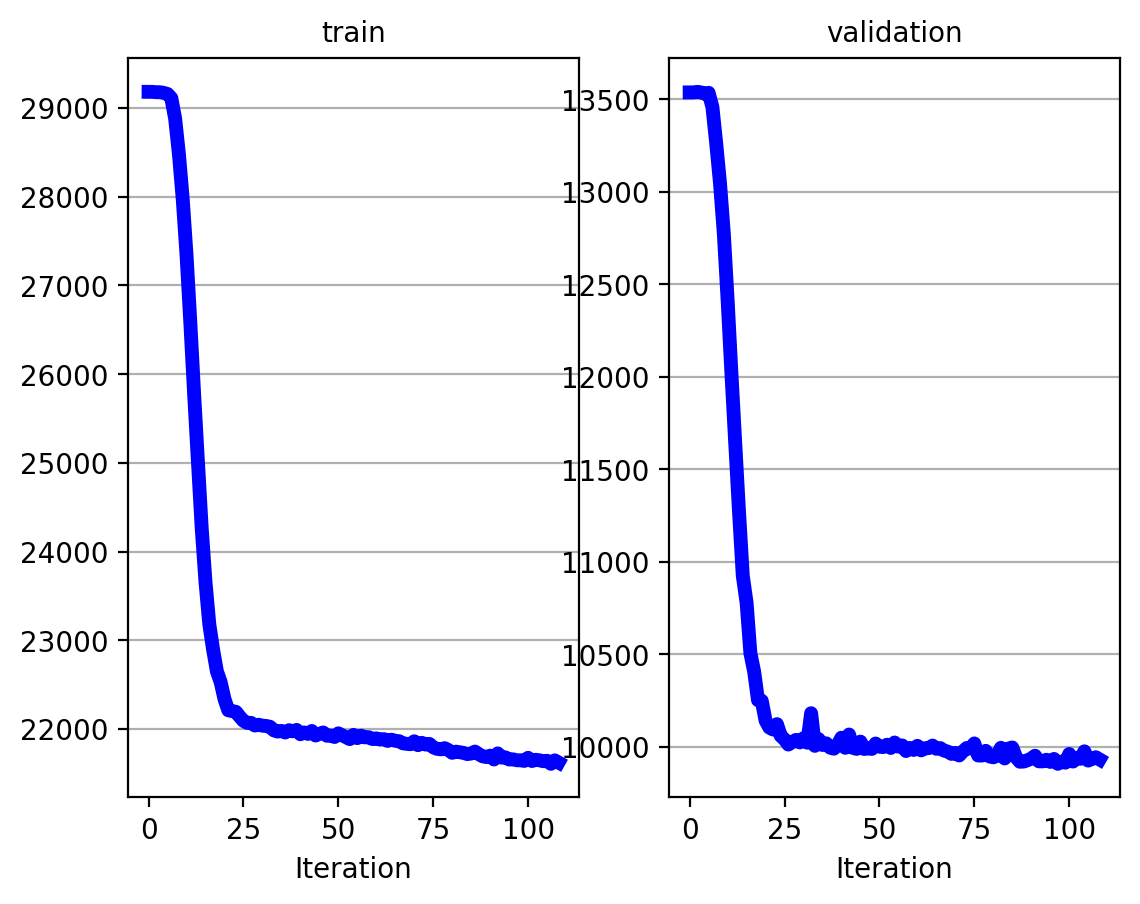

Training model:  VAE CONV1 
Epoch 1/200: Train Cross-Entropy: 88.703756
Epoch 1/200: Validation Cross-Entropy: 88.467454
Epoch 2/200: Train Cross-Entropy: 88.710483
Epoch 2/200: Validation Cross-Entropy: 88.489334
Epoch 3/200: Train Cross-Entropy: 88.685669
Epoch 3/200: Validation Cross-Entropy: 88.446972
Epoch 4/200: Train Cross-Entropy: 88.671345
Epoch 4/200: Validation Cross-Entropy: 88.461186
Epoch 5/200: Train Cross-Entropy: 88.636402
Epoch 5/200: Validation Cross-Entropy: 88.378779
Epoch 6/200: Train Cross-Entropy: 88.521762
Epoch 6/200: Validation Cross-Entropy: 88.111960
Epoch 7/200: Train Cross-Entropy: 87.624846
Epoch 7/200: Validation Cross-Entropy: 86.273789
Epoch 8/200: Train Cross-Entropy: 85.823419
Epoch 8/200: Validation Cross-Entropy: 84.314000
Epoch 9/200: Train Cross-Entropy: 83.489857
Epoch 9/200: Validation Cross-Entropy: 81.862611
Epoch 10/200: Train Cross-Entropy: 80.724015
Epoch 10/200: Validation Cross-Entropy: 79.158280
Epoch 11/200: Train Cross-Entropy: 77.61

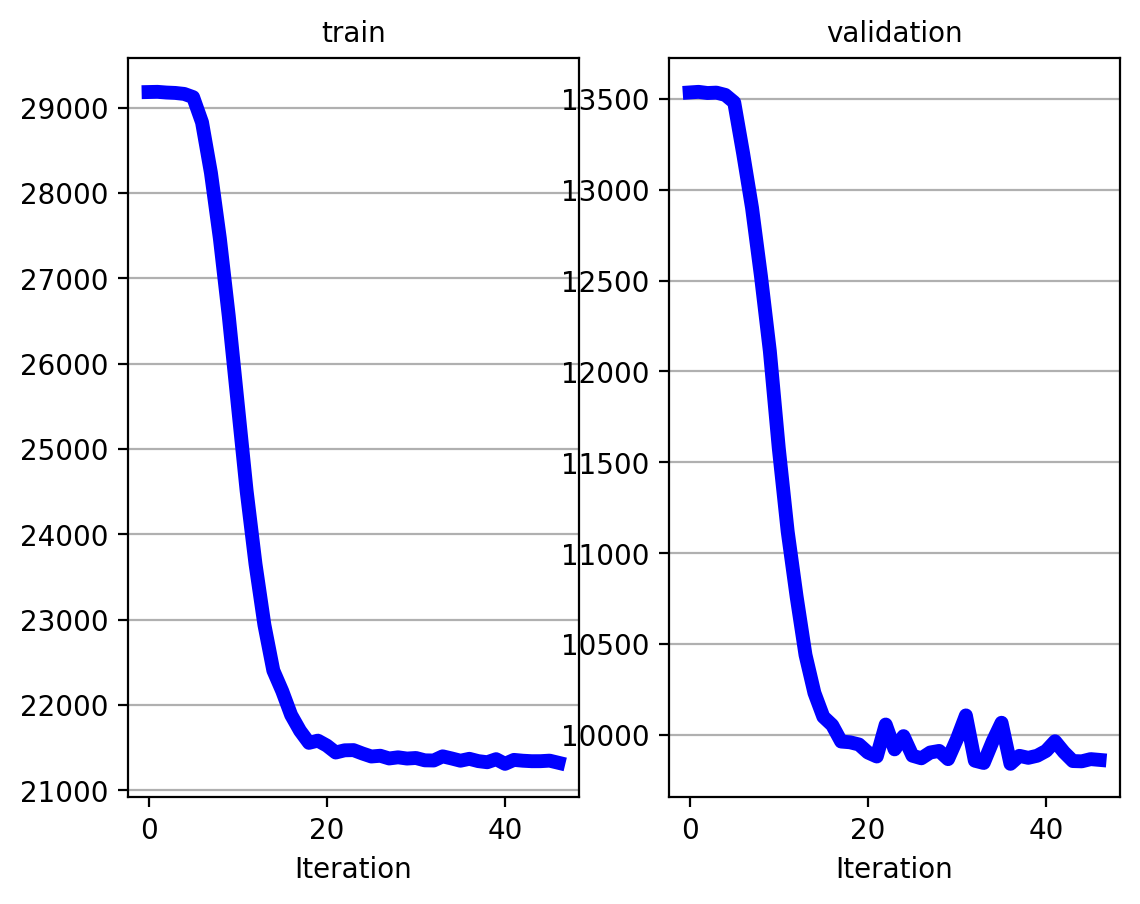

Training model:  VAE CONV3
Epoch 1/200: Train Cross-Entropy: 88.699193
Epoch 1/200: Validation Cross-Entropy: 88.459801
Epoch 2/200: Train Cross-Entropy: 88.647337
Epoch 2/200: Validation Cross-Entropy: 88.374055
Epoch 3/200: Train Cross-Entropy: 88.469673
Epoch 3/200: Validation Cross-Entropy: 87.989054
Epoch 4/200: Train Cross-Entropy: 86.215811
Epoch 4/200: Validation Cross-Entropy: 82.614915
Epoch 5/200: Train Cross-Entropy: 79.894193
Epoch 5/200: Validation Cross-Entropy: 75.808370
Epoch 6/200: Train Cross-Entropy: 73.349942
Epoch 6/200: Validation Cross-Entropy: 70.122689
Epoch 7/200: Train Cross-Entropy: 68.998127
Epoch 7/200: Validation Cross-Entropy: 66.789860
Epoch 8/200: Train Cross-Entropy: 66.863252
Epoch 8/200: Validation Cross-Entropy: 65.738785
Epoch 9/200: Train Cross-Entropy: 65.676967
Epoch 9/200: Validation Cross-Entropy: 66.438904
Epoch 10/200: Train Cross-Entropy: 65.273739
Epoch 10/200: Validation Cross-Entropy: 64.352699
Epoch 11/200: Train Cross-Entropy: 65.030

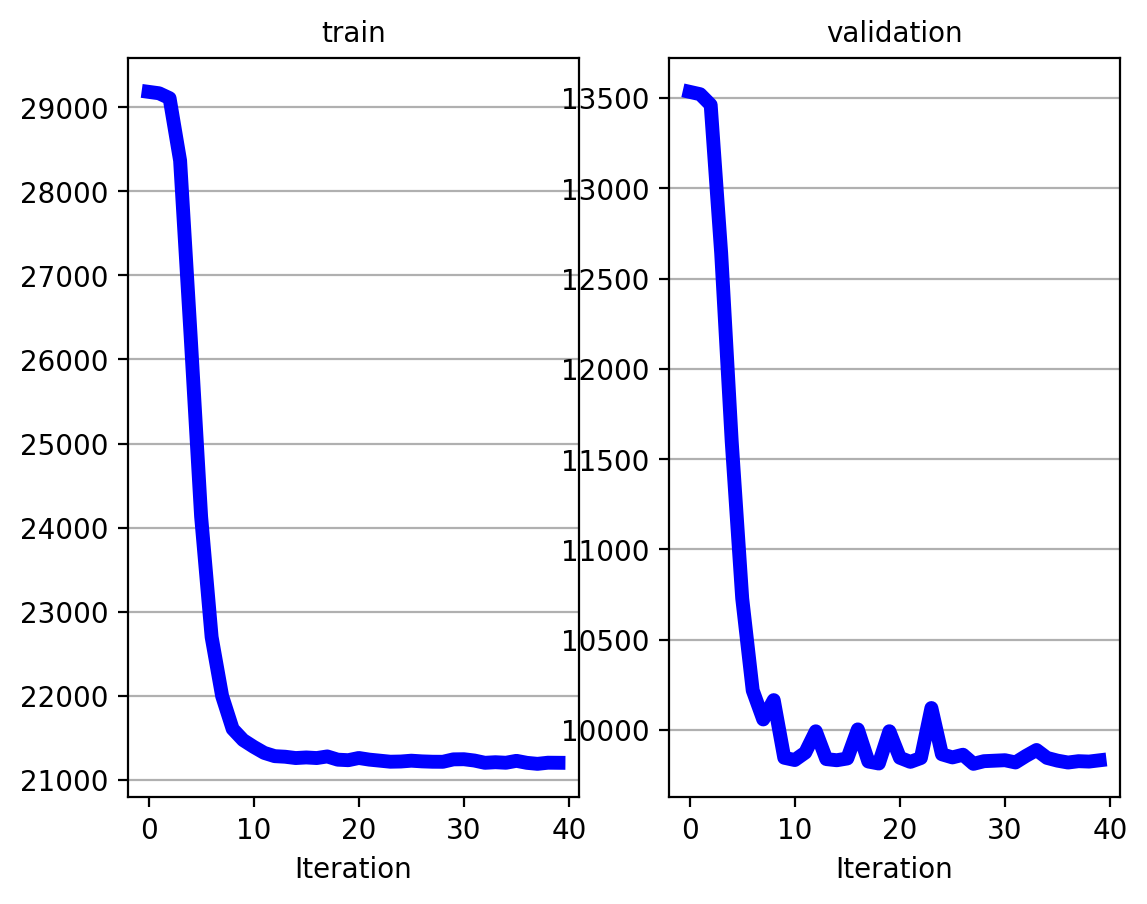

Training model:  VAE FD1
Epoch 1/200: Train Cross-Entropy: 88.697935
Epoch 1/200: Validation Cross-Entropy: 88.491683
Epoch 2/200: Train Cross-Entropy: 88.700792
Epoch 2/200: Validation Cross-Entropy: 88.457791
Epoch 3/200: Train Cross-Entropy: 88.667212
Epoch 3/200: Validation Cross-Entropy: 88.424339
Epoch 4/200: Train Cross-Entropy: 88.612330
Epoch 4/200: Validation Cross-Entropy: 88.315685
Epoch 5/200: Train Cross-Entropy: 88.340044
Epoch 5/200: Validation Cross-Entropy: 87.916890
Epoch 6/200: Train Cross-Entropy: 86.171570
Epoch 6/200: Validation Cross-Entropy: 83.854441
Epoch 7/200: Train Cross-Entropy: 82.923106
Epoch 7/200: Validation Cross-Entropy: 80.715699
Epoch 8/200: Train Cross-Entropy: 79.348859
Epoch 8/200: Validation Cross-Entropy: 77.399280
Epoch 9/200: Train Cross-Entropy: 75.631200
Epoch 9/200: Validation Cross-Entropy: 73.143842
Epoch 10/200: Train Cross-Entropy: 72.436570
Epoch 10/200: Validation Cross-Entropy: 70.186268
Epoch 11/200: Train Cross-Entropy: 69.81980

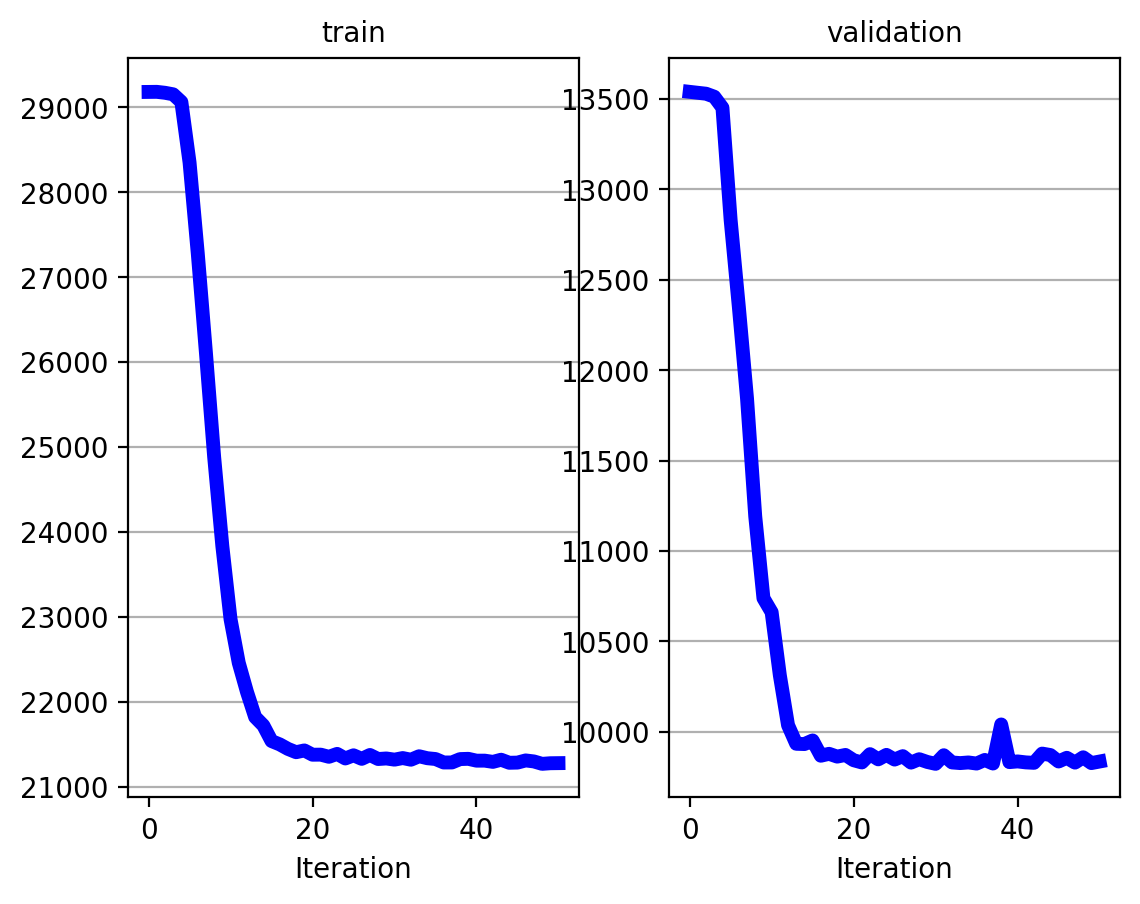

Training model:  VAE FD2
Epoch 1/200: Train Cross-Entropy: 88.693596
Epoch 1/200: Validation Cross-Entropy: 88.469714
Epoch 2/200: Train Cross-Entropy: 88.688634
Epoch 2/200: Validation Cross-Entropy: 88.467614
Epoch 3/200: Train Cross-Entropy: 88.685707
Epoch 3/200: Validation Cross-Entropy: 88.463899
Epoch 4/200: Train Cross-Entropy: 88.685378
Epoch 4/200: Validation Cross-Entropy: 88.458940
Epoch 5/200: Train Cross-Entropy: 88.676153
Epoch 5/200: Validation Cross-Entropy: 88.452410
Epoch 6/200: Train Cross-Entropy: 88.658955
Epoch 6/200: Validation Cross-Entropy: 88.443372
Epoch 7/200: Train Cross-Entropy: 88.640320
Epoch 7/200: Validation Cross-Entropy: 88.422666
Epoch 8/200: Train Cross-Entropy: 88.590237
Epoch 8/200: Validation Cross-Entropy: 88.308319
Epoch 9/200: Train Cross-Entropy: 88.365738
Epoch 9/200: Validation Cross-Entropy: 87.668907
Epoch 10/200: Train Cross-Entropy: 87.381161
Epoch 10/200: Validation Cross-Entropy: 86.547871
Epoch 11/200: Train Cross-Entropy: 86.10574

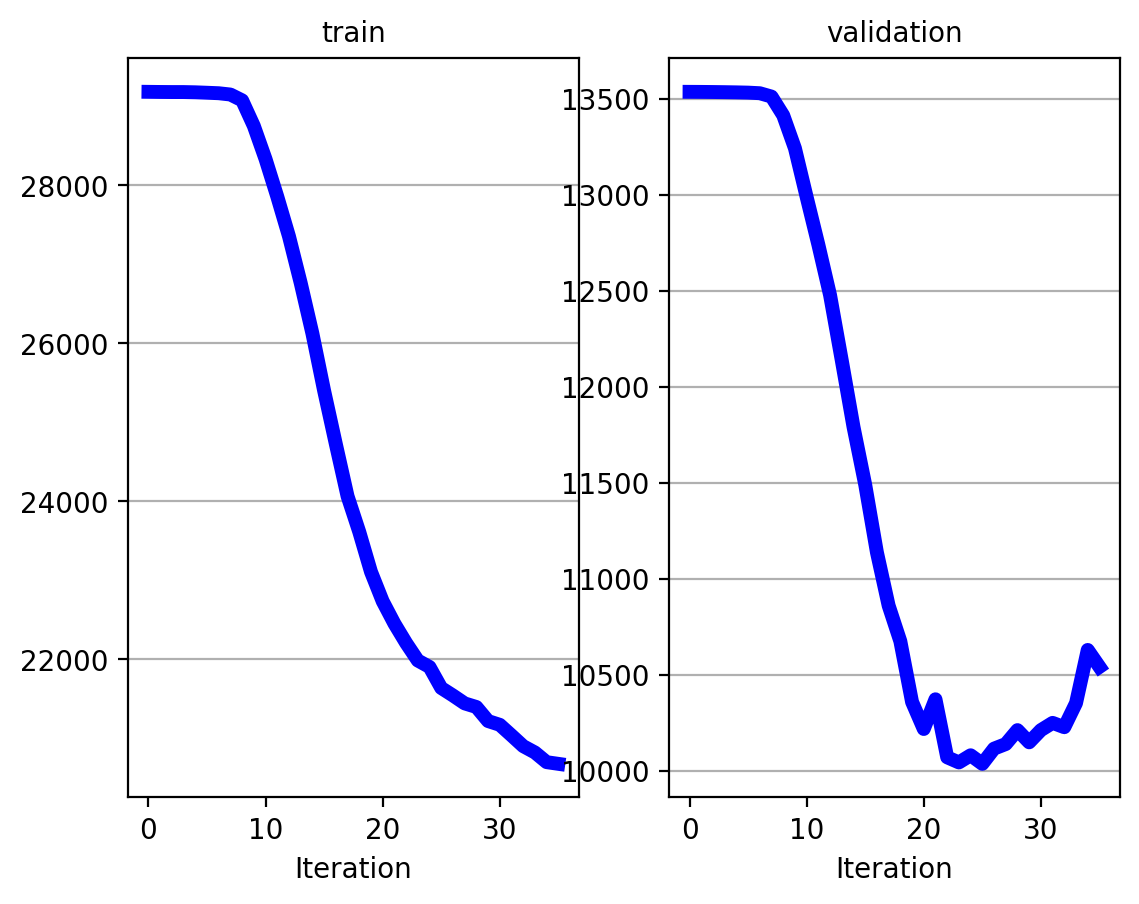

Training model:  VQ VAE CONV2
Epoch 1/200: Train Cross-Entropy: 88.695851
Epoch 1/200: Validation Cross-Entropy: 88.476167
Epoch 2/200: Train Cross-Entropy: 88.686512
Epoch 2/200: Validation Cross-Entropy: 88.453642
Epoch 3/200: Train Cross-Entropy: 88.677445
Epoch 3/200: Validation Cross-Entropy: 88.424524
Epoch 4/200: Train Cross-Entropy: 88.618635
Epoch 4/200: Validation Cross-Entropy: 88.358935
Epoch 5/200: Train Cross-Entropy: 88.414231
Epoch 5/200: Validation Cross-Entropy: 87.574780
Epoch 6/200: Train Cross-Entropy: 87.188351
Epoch 6/200: Validation Cross-Entropy: 86.078993
Epoch 7/200: Train Cross-Entropy: 84.671770
Epoch 7/200: Validation Cross-Entropy: 83.235824
Epoch 8/200: Train Cross-Entropy: 81.426342
Epoch 8/200: Validation Cross-Entropy: 79.087425
Epoch 9/200: Train Cross-Entropy: 77.618690
Epoch 9/200: Validation Cross-Entropy: 74.907967
Epoch 10/200: Train Cross-Entropy: 74.016447
Epoch 10/200: Validation Cross-Entropy: 71.330959
Epoch 11/200: Train Cross-Entropy: 71.

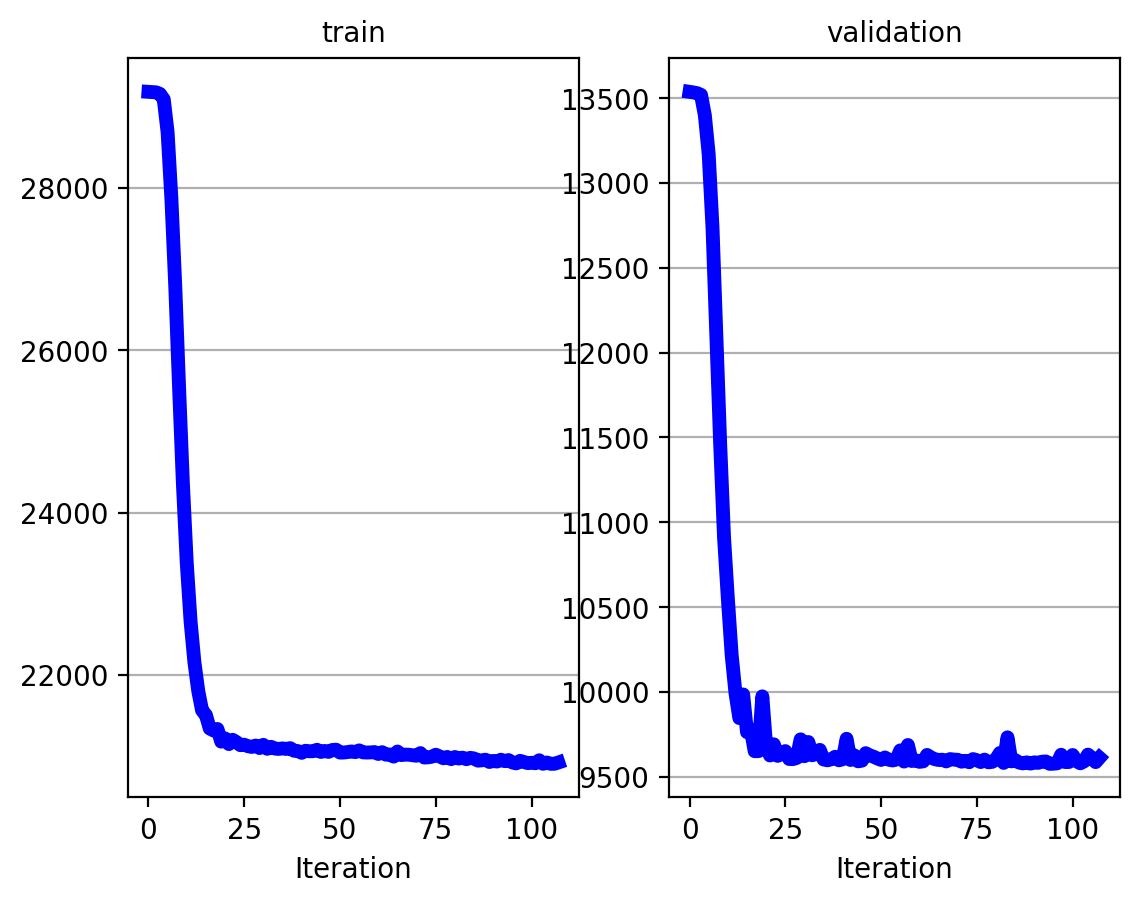

Training model:  VQ VAE FD1
Epoch 1/200: Train Cross-Entropy: 88.700480
Epoch 1/200: Validation Cross-Entropy: 88.498717
Epoch 2/200: Train Cross-Entropy: 88.695160
Epoch 2/200: Validation Cross-Entropy: 88.472012
Epoch 3/200: Train Cross-Entropy: 88.689037
Epoch 3/200: Validation Cross-Entropy: 88.453948
Epoch 4/200: Train Cross-Entropy: 88.670700
Epoch 4/200: Validation Cross-Entropy: 88.429573
Epoch 5/200: Train Cross-Entropy: 88.619985
Epoch 5/200: Validation Cross-Entropy: 88.374643
Epoch 6/200: Train Cross-Entropy: 88.494801
Epoch 6/200: Validation Cross-Entropy: 88.053513
Epoch 7/200: Train Cross-Entropy: 87.603701
Epoch 7/200: Validation Cross-Entropy: 86.693857
Epoch 8/200: Train Cross-Entropy: 86.032636
Epoch 8/200: Validation Cross-Entropy: 84.451587
Epoch 9/200: Train Cross-Entropy: 83.529204
Epoch 9/200: Validation Cross-Entropy: 81.457172
Epoch 10/200: Train Cross-Entropy: 80.680346
Epoch 10/200: Validation Cross-Entropy: 78.332784
Epoch 11/200: Train Cross-Entropy: 77.38

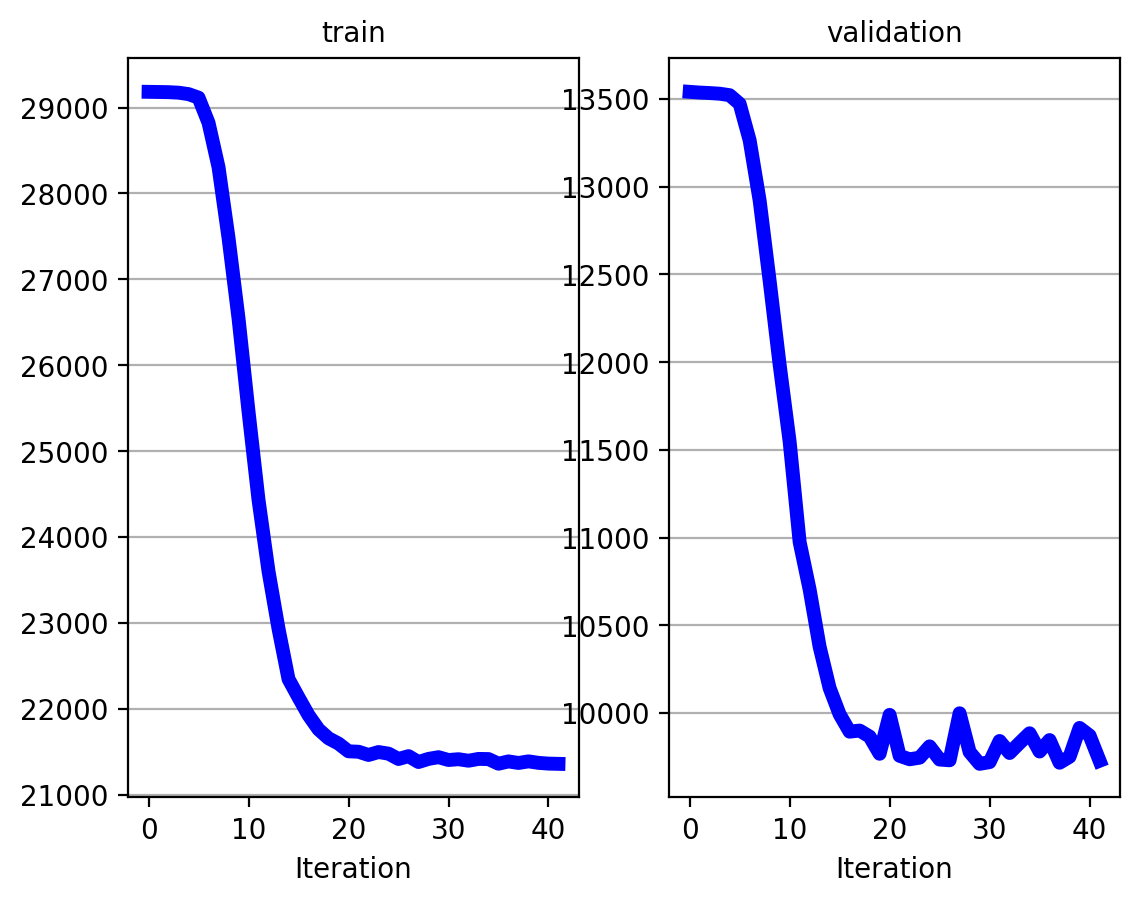

In [26]:
device = 'mps'
n_epochs = 200
batch_size = 128
learning_rate = 0.0001
for model, synth in generated.items():
    print('Training model: ', model)
    model_name = model.replace(' ', '_')
    model_name = model_name.lower()
    model_name = model_name.strip()

    synth_data = {'Trainig': synth[:,0:n_train],
                'Validation': synth[:,n_train:n_test],
                'Test': synth[:,n_test:]}

    synth_data_sq = {}


    for key, value in synth_data.items():
        x, y = create_sequences(value, seq_length)
        synth_data_sq[key] = {'X': x, 'y': y}    

    x_train = synth_data_sq['Trainig']['X']
    y_train = synth_data_sq['Trainig']['y']
    x_val = synth_data_sq['Validation']['X']
    y_val = synth_data_sq['Validation']['y']


    lstm_model = LSTM_Model().to(device)
    early_stopper = EarlyStopper(patience=10, min_delta=10)
    optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss(reduction="sum")
    loader_train = datatools.DataLoader(datatools.TensorDataset(x_train, y_train ), shuffle=True, batch_size=batch_size)
    loader_test = datatools.DataLoader(datatools.TensorDataset(x_val, y_val), shuffle=False, batch_size=batch_size)
    best_model, synth_lstm_model, loss_train, loss_validation = train(lstm_model, loader_train, loader_test, n_epochs, early_stopper, device)
    torch.save(best_model, models_dir+f"best_synth_lstm_{model_name}.pth")

# Train on Real data + Synthetic data

Training model:  TIME VAE BASE
Epoch 1/100: Train Cross-Entropy: 88.711930
Epoch 1/100: Validation Cross-Entropy: 88.462035
Epoch 2/100: Train Cross-Entropy: 88.665515
Epoch 2/100: Validation Cross-Entropy: 88.132047
Epoch 3/100: Train Cross-Entropy: 86.854992
Epoch 3/100: Validation Cross-Entropy: 80.382685
Epoch 4/100: Train Cross-Entropy: 79.469759
Epoch 4/100: Validation Cross-Entropy: 70.543569
Epoch 5/100: Train Cross-Entropy: 72.076298
Epoch 5/100: Validation Cross-Entropy: 72.547641
Epoch 6/100: Train Cross-Entropy: 68.524960
Epoch 6/100: Validation Cross-Entropy: 77.842888
Epoch 7/100: Train Cross-Entropy: 67.590785
Epoch 7/100: Validation Cross-Entropy: 79.680313
Epoch 8/100: Train Cross-Entropy: 67.293474
Epoch 8/100: Validation Cross-Entropy: 82.179828
Epoch 9/100: Train Cross-Entropy: 67.132538
Epoch 9/100: Validation Cross-Entropy: 82.327857
Epoch 10/100: Train Cross-Entropy: 67.021808
Epoch 10/100: Validation Cross-Entropy: 83.311115
Epoch 11/100: Train Cross-Entropy: 66

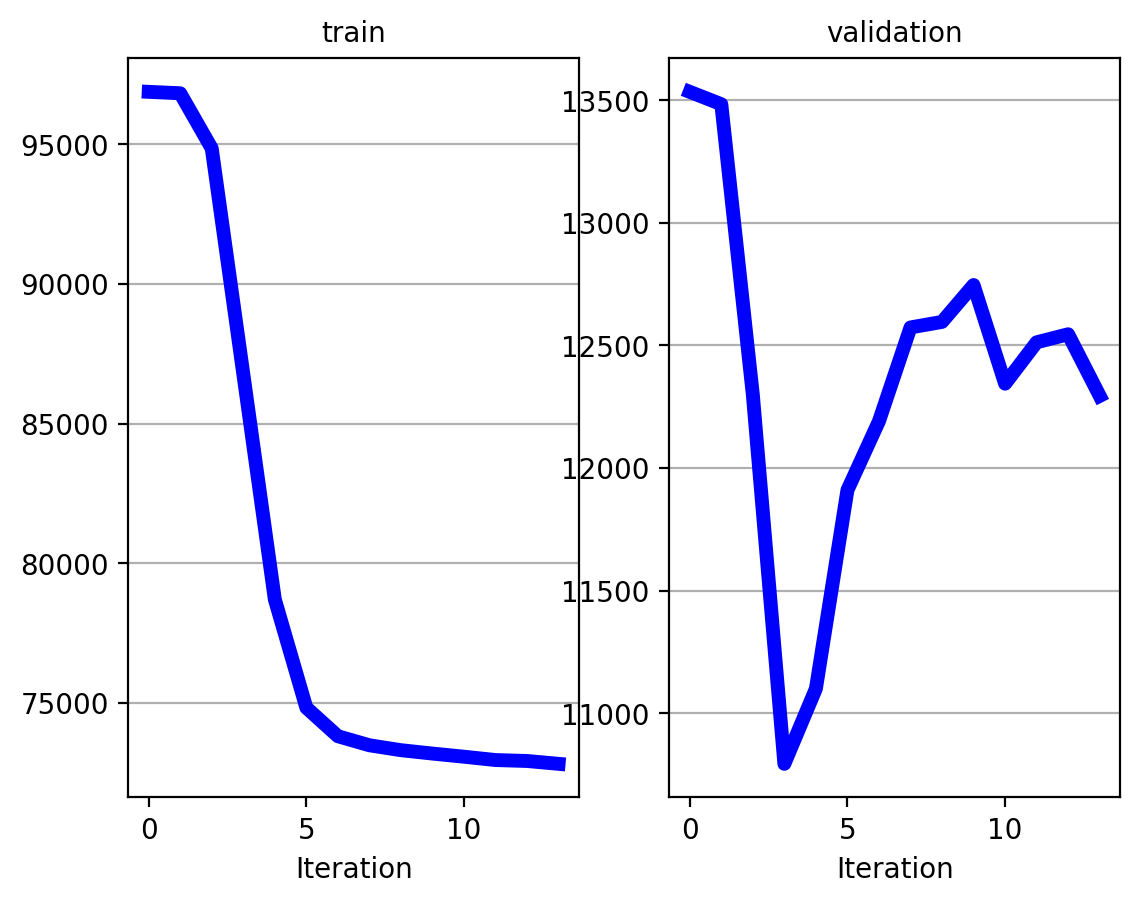

Training model:  VAE CONV1 
Epoch 1/100: Train Cross-Entropy: 88.710712
Epoch 1/100: Validation Cross-Entropy: 88.426917
Epoch 2/100: Train Cross-Entropy: 88.642286
Epoch 2/100: Validation Cross-Entropy: 88.169533
Epoch 3/100: Train Cross-Entropy: 86.286357
Epoch 3/100: Validation Cross-Entropy: 79.472407
Epoch 4/100: Train Cross-Entropy: 78.041169
Epoch 4/100: Validation Cross-Entropy: 69.778639
Epoch 5/100: Train Cross-Entropy: 70.118022
Epoch 5/100: Validation Cross-Entropy: 73.064319
Epoch 6/100: Train Cross-Entropy: 66.835300
Epoch 6/100: Validation Cross-Entropy: 75.217416
Epoch 7/100: Train Cross-Entropy: 65.801383
Epoch 7/100: Validation Cross-Entropy: 76.763819
Epoch 8/100: Train Cross-Entropy: 65.514326
Epoch 8/100: Validation Cross-Entropy: 77.217154
Epoch 9/100: Train Cross-Entropy: 65.351772
Epoch 9/100: Validation Cross-Entropy: 78.787933
Epoch 10/100: Train Cross-Entropy: 65.238802
Epoch 10/100: Validation Cross-Entropy: 77.413188
Epoch 11/100: Train Cross-Entropy: 65.26

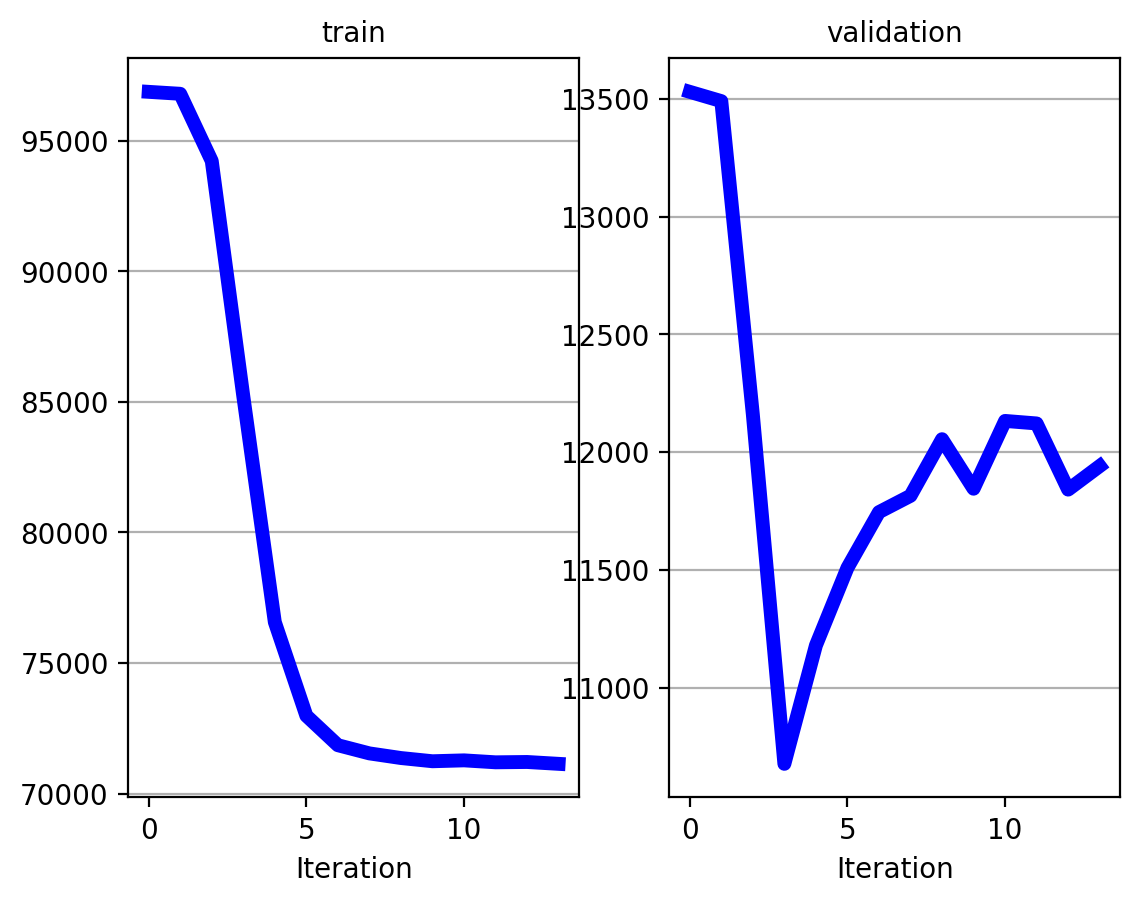

Training model:  VAE CONV3
Epoch 1/100: Train Cross-Entropy: 88.654564
Epoch 1/100: Validation Cross-Entropy: 88.718150
Epoch 2/100: Train Cross-Entropy: 81.514362
Epoch 2/100: Validation Cross-Entropy: 77.261087
Epoch 3/100: Train Cross-Entropy: 69.397975
Epoch 3/100: Validation Cross-Entropy: 71.793760
Epoch 4/100: Train Cross-Entropy: 66.951573
Epoch 4/100: Validation Cross-Entropy: 70.247064
Epoch 5/100: Train Cross-Entropy: 66.523557
Epoch 5/100: Validation Cross-Entropy: 69.839697
Epoch 6/100: Train Cross-Entropy: 66.420109
Epoch 6/100: Validation Cross-Entropy: 70.293467
Epoch 7/100: Train Cross-Entropy: 66.341636
Epoch 7/100: Validation Cross-Entropy: 70.836901
Epoch 8/100: Train Cross-Entropy: 66.303443
Epoch 8/100: Validation Cross-Entropy: 69.746055
Epoch 9/100: Train Cross-Entropy: 66.291624
Epoch 9/100: Validation Cross-Entropy: 69.751621
Epoch 10/100: Train Cross-Entropy: 66.302207
Epoch 10/100: Validation Cross-Entropy: 70.062749
Epoch 11/100: Train Cross-Entropy: 66.280

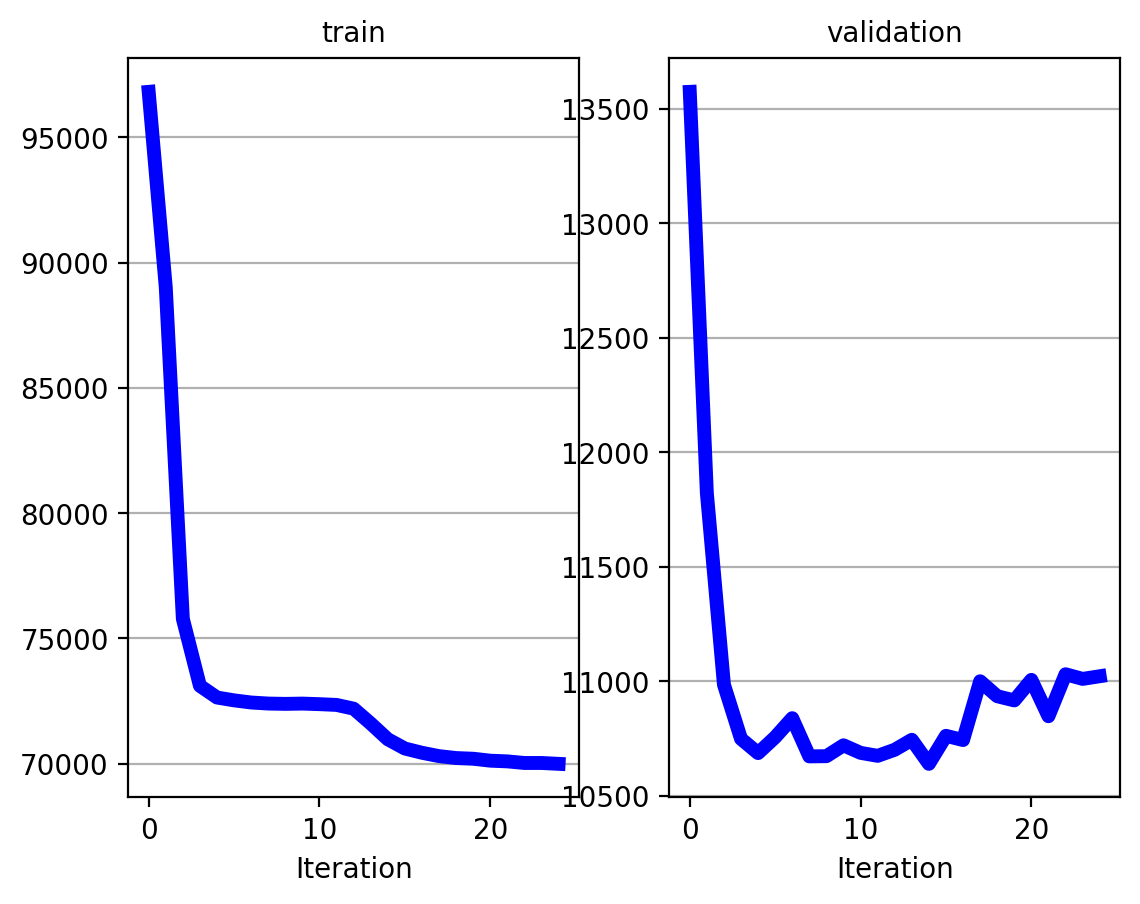

Training model:  VAE FD1
Epoch 1/100: Train Cross-Entropy: 88.703583
Epoch 1/100: Validation Cross-Entropy: 88.478975
Epoch 2/100: Train Cross-Entropy: 87.982316
Epoch 2/100: Validation Cross-Entropy: 83.616619
Epoch 3/100: Train Cross-Entropy: 77.840487
Epoch 3/100: Validation Cross-Entropy: 71.559858
Epoch 4/100: Train Cross-Entropy: 68.387933
Epoch 4/100: Validation Cross-Entropy: 69.153876
Epoch 5/100: Train Cross-Entropy: 65.859776
Epoch 5/100: Validation Cross-Entropy: 69.573670
Epoch 6/100: Train Cross-Entropy: 65.373823
Epoch 6/100: Validation Cross-Entropy: 70.194604
Epoch 7/100: Train Cross-Entropy: 65.220895
Epoch 7/100: Validation Cross-Entropy: 70.591114
Epoch 8/100: Train Cross-Entropy: 65.044819
Epoch 8/100: Validation Cross-Entropy: 70.079963
Epoch 9/100: Train Cross-Entropy: 65.011240
Epoch 9/100: Validation Cross-Entropy: 70.037837
Epoch 10/100: Train Cross-Entropy: 65.019445
Epoch 10/100: Validation Cross-Entropy: 70.679688
Epoch 11/100: Train Cross-Entropy: 64.94061

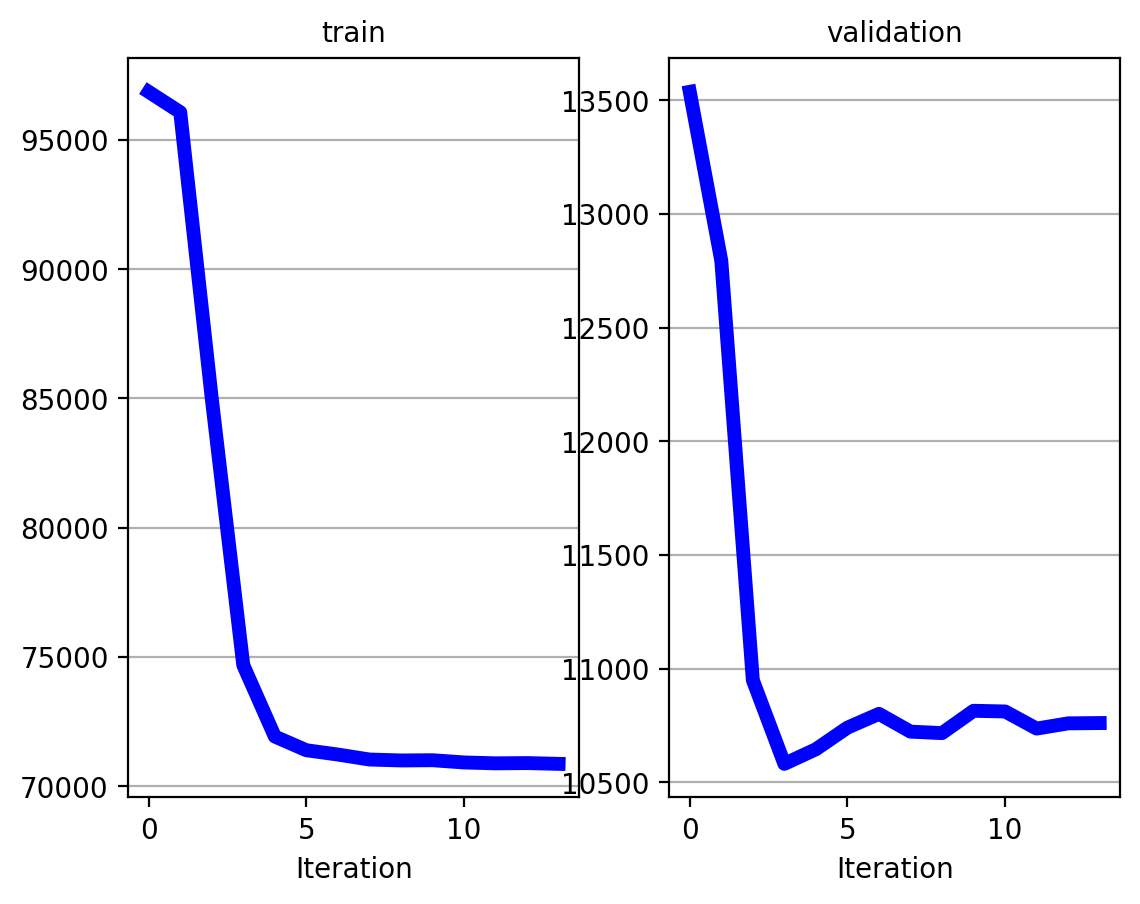

Training model:  VAE FD2
Epoch 1/100: Train Cross-Entropy: 88.710578
Epoch 1/100: Validation Cross-Entropy: 88.439702
Epoch 2/100: Train Cross-Entropy: 88.678549
Epoch 2/100: Validation Cross-Entropy: 88.346246
Epoch 3/100: Train Cross-Entropy: 87.958888
Epoch 3/100: Validation Cross-Entropy: 83.395278
Epoch 4/100: Train Cross-Entropy: 82.643429
Epoch 4/100: Validation Cross-Entropy: 72.507730
Epoch 5/100: Train Cross-Entropy: 75.453131
Epoch 5/100: Validation Cross-Entropy: 70.503600
Epoch 6/100: Train Cross-Entropy: 70.431798
Epoch 6/100: Validation Cross-Entropy: 75.236162
Epoch 7/100: Train Cross-Entropy: 68.216649
Epoch 7/100: Validation Cross-Entropy: 79.982479
Epoch 8/100: Train Cross-Entropy: 67.381571
Epoch 8/100: Validation Cross-Entropy: 83.539126
Epoch 9/100: Train Cross-Entropy: 67.098962
Epoch 9/100: Validation Cross-Entropy: 84.692242
Epoch 10/100: Train Cross-Entropy: 66.923573
Epoch 10/100: Validation Cross-Entropy: 85.964869
Epoch 11/100: Train Cross-Entropy: 66.92369

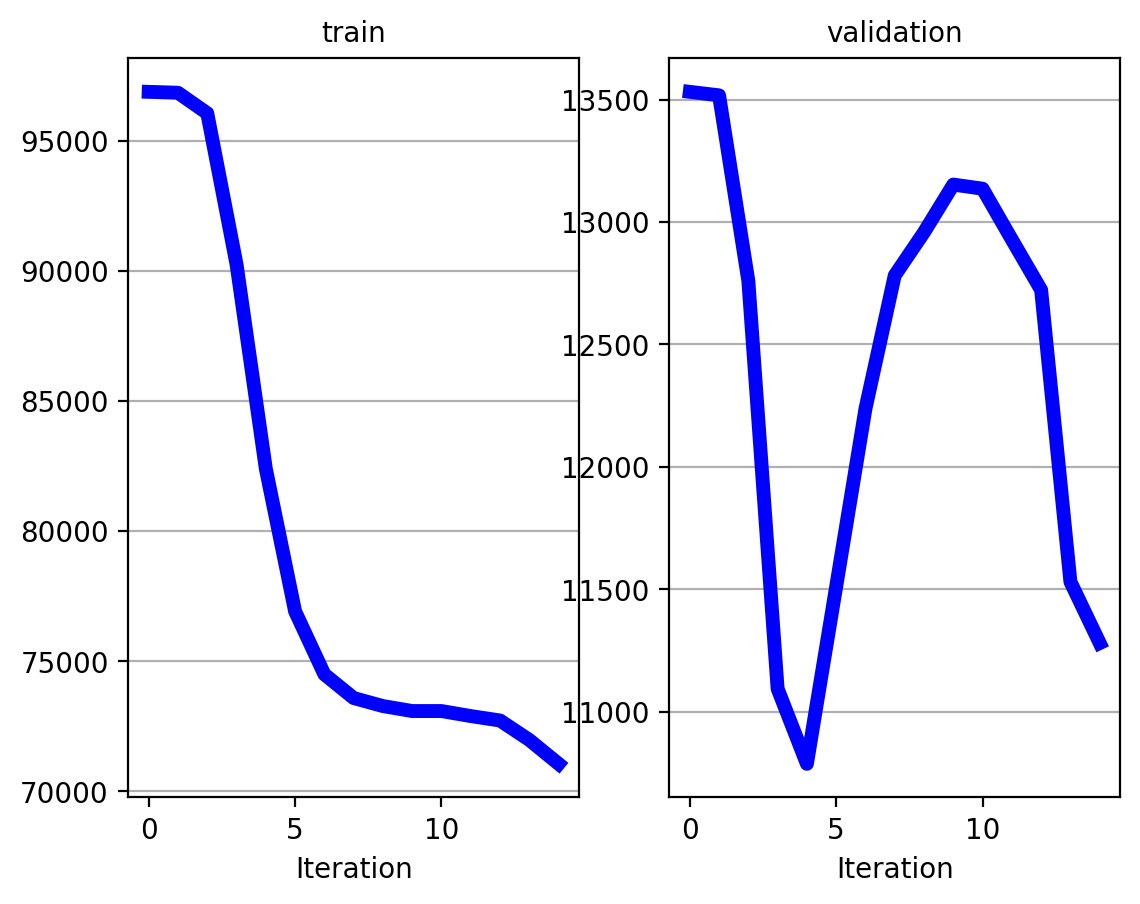

Training model:  VQ VAE CONV2
Epoch 1/100: Train Cross-Entropy: 88.691416
Epoch 1/100: Validation Cross-Entropy: 88.345671
Epoch 2/100: Train Cross-Entropy: 86.834813
Epoch 2/100: Validation Cross-Entropy: 81.514265
Epoch 3/100: Train Cross-Entropy: 76.371875
Epoch 3/100: Validation Cross-Entropy: 71.089065
Epoch 4/100: Train Cross-Entropy: 67.656678
Epoch 4/100: Validation Cross-Entropy: 72.344427
Epoch 5/100: Train Cross-Entropy: 64.916227
Epoch 5/100: Validation Cross-Entropy: 70.649574
Epoch 6/100: Train Cross-Entropy: 64.329400
Epoch 6/100: Validation Cross-Entropy: 71.725886
Epoch 7/100: Train Cross-Entropy: 64.078753
Epoch 7/100: Validation Cross-Entropy: 71.595378
Epoch 8/100: Train Cross-Entropy: 64.006171
Epoch 8/100: Validation Cross-Entropy: 72.461793
Epoch 9/100: Train Cross-Entropy: 63.940114
Epoch 9/100: Validation Cross-Entropy: 72.307202
Epoch 10/100: Train Cross-Entropy: 63.982615
Epoch 10/100: Validation Cross-Entropy: 74.103969
Epoch 11/100: Train Cross-Entropy: 63.

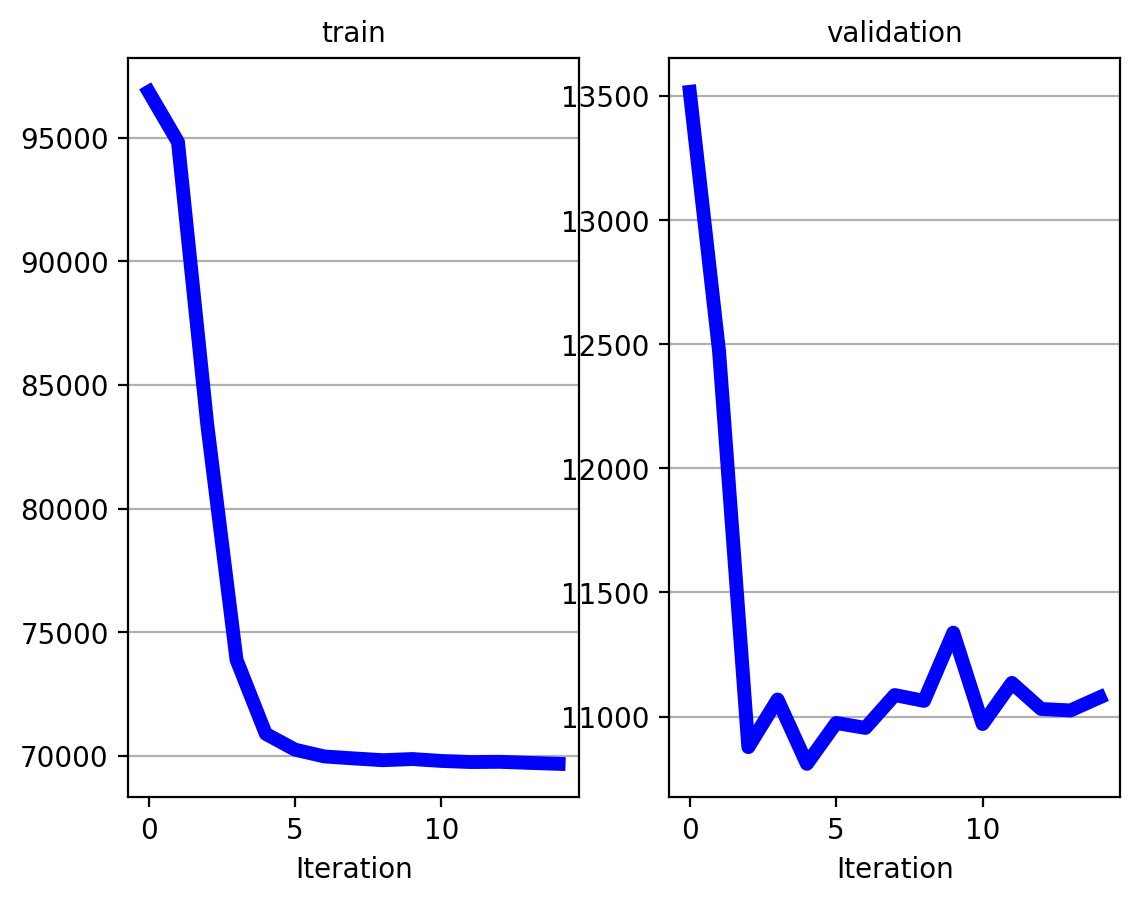

Training model:  VQ VAE FD1
Epoch 1/100: Train Cross-Entropy: 88.705194
Epoch 1/100: Validation Cross-Entropy: 88.423503
Epoch 2/100: Train Cross-Entropy: 88.428440
Epoch 2/100: Validation Cross-Entropy: 85.862420
Epoch 3/100: Train Cross-Entropy: 83.049410
Epoch 3/100: Validation Cross-Entropy: 75.147729
Epoch 4/100: Train Cross-Entropy: 73.285670
Epoch 4/100: Validation Cross-Entropy: 70.250211
Epoch 5/100: Train Cross-Entropy: 67.446762
Epoch 5/100: Validation Cross-Entropy: 72.238945
Epoch 6/100: Train Cross-Entropy: 65.738435
Epoch 6/100: Validation Cross-Entropy: 76.145335
Epoch 7/100: Train Cross-Entropy: 65.193786
Epoch 7/100: Validation Cross-Entropy: 75.991900
Epoch 8/100: Train Cross-Entropy: 64.997258
Epoch 8/100: Validation Cross-Entropy: 76.195402
Epoch 9/100: Train Cross-Entropy: 64.906398
Epoch 9/100: Validation Cross-Entropy: 74.979013
Epoch 10/100: Train Cross-Entropy: 64.898034
Epoch 10/100: Validation Cross-Entropy: 75.332146
Epoch 11/100: Train Cross-Entropy: 64.83

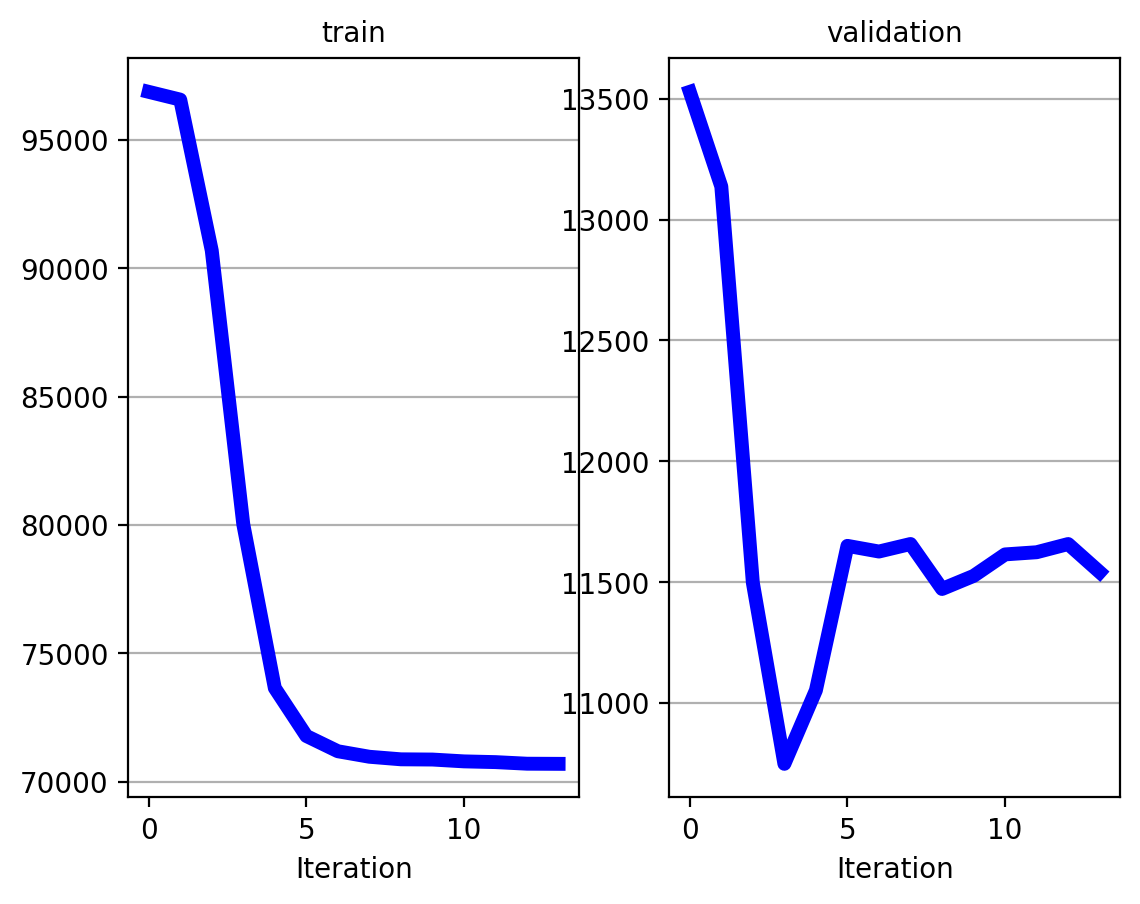

In [18]:
device = 'mps'
n_epochs = 100
batch_size = 128
learning_rate = 0.0001

device = 'mps'
n_epochs = 100
batch_size = 128
learning_rate = 0.0001
for model, synth in generated.items():
    print('Training model: ', model)
    model_name = model.replace(' ', '_')
    model_name = model_name.lower()
    model_name = model_name.strip()

    x_synth, y_synth = create_sequences(synth, seq_length)

    x_train = np.concatenate((x_synth, real_data_sq['Trainig']['X']), axis=0)
    y_train = np.concatenate((y_synth , real_data_sq['Trainig']['y']), axis=0)
    x_train = torch.tensor(x_train, dtype=torch.float32).reshape(-1, seq_length, 1)
    y_train = torch.tensor(y_train)

    x_val = real_data_sq['Validation']['X']
    y_val = real_data_sq['Validation']['y']


    lstm_model = LSTM_Model().to(device)
    early_stopper = EarlyStopper(patience=10, min_delta=10)
    optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss(reduction="sum")
    loader_train = datatools.DataLoader(datatools.TensorDataset(x_train, y_train ), shuffle=True, batch_size=batch_size)
    loader_test = datatools.DataLoader(datatools.TensorDataset(x_val, y_val), shuffle=False, batch_size=batch_size)
    best_model, aug_lstm_model, loss_train, loss_validation = train(lstm_model, loader_train, loader_test, n_epochs, early_stopper, device)
    torch.save(best_model, models_dir+f"best_aug_lstm_{model_name}.pth")

# Testing on real Data

In [19]:
x_test = real_data_sq['Test']['X']
y_test = real_data_sq['Test']['y']
device = 'mps'

x_test = x_test.to(device)

real_lstm_model = LSTM_Model().to(device) 
real_lstm_model.load_state_dict(torch.load(models_dir+"best_real_lstm.pth"))

real_lstm_model.eval()
y_pred = real_lstm_model(x_test)
y_pred = torch.argmax(y_pred, dim=1)
y_pred = y_pred.cpu().numpy()
key = 'Real Data LSTM'
print(f'Accuracy score {key}: ')
print(accuracy_score(y_test, y_pred))
print('')
print(f'ROC AUC score {key}: ')
print(roc_auc_score(y_test, y_pred))
# print('')
# print(f'Confusion matrix {key}: ')
# print(confusion_matrix(y_test, y_pred))
print('')
print(f'Classification report {key}: ')
print(classification_report(y_test, y_pred))

Accuracy score Real Data LSTM: 
0.738424402018872

ROC AUC score Real Data LSTM: 
0.7395415122824437

Classification report Real Data LSTM: 
              precision    recall  f1-score   support

           0       0.77      0.69      0.73      4659
           1       0.71      0.79      0.75      4455

    accuracy                           0.74      9114
   macro avg       0.74      0.74      0.74      9114
weighted avg       0.74      0.74      0.74      9114



In [27]:
model_name
synth_lstm_model = LSTM_Model().to(device)
dir_ = models_dir+f"best_synth_lstm_{model_name}.pth"
print(dir_)
synth_lstm_model.load_state_dict(torch.load(dir_))

models/best_synth_lstm_vq_vae_fd1.pth


<All keys matched successfully>

In [32]:
results = {}
for model_name, synth in generated.items():
    print('Testing model: ', model_name)
    
    model_name = model_name.replace(' ', '_')
    model_name = model_name.lower()
    model_name = model_name.strip()

    synth_lstm_model = LSTM_Model().to(device)
    synth_lstm_model.load_state_dict(torch.load(models_dir+f"best_synth_lstm_{model_name}.pth"))
    aug_lstm_model = LSTM_Model().to(device)
    aug_lstm_model.load_state_dict(torch.load(models_dir+f"best_aug_lstm_{model_name}.pth"))   

    models = { 'Synthetic': synth_lstm_model, 'Augmented': aug_lstm_model}


# x_test = real_data_sq['Test']['X']
# y_test = real_data_sq['Test']['y']

# device = 'mps'

# x_test = x_test.to(device)
    results[model_name] = {}
    for key, model in models.items():
        model.eval()
        y_pred = model(x_test)
        y_pred = torch.argmax(y_pred, dim=1)
        y_pred = y_pred.cpu().numpy()

        print(f'Accuracy score {key}: ')
        acc =  accuracy_score(y_test, y_pred)
        print(acc)
        print('')
        print(f'ROC AUC score {key}: ')
        print(roc_auc_score(y_test, y_pred))
        # print('')
        # print(f'Confusion matrix {key}: ')
        # print(confusion_matrix(y_test, y_pred))
        print('')
        print(f'Classification report {key}: ')
        print(classification_report(y_test, y_pred))
        results[model_name][key] = acc


Testing model:  TIME VAE BASE
Accuracy score Synthetic: 
0.7363396971691902

ROC AUC score Synthetic: 
0.7358414220187132

Classification report Synthetic: 
              precision    recall  f1-score   support

           0       0.73      0.76      0.75      4659
           1       0.74      0.71      0.73      4455

    accuracy                           0.74      9114
   macro avg       0.74      0.74      0.74      9114
weighted avg       0.74      0.74      0.74      9114

Accuracy score Augmented: 
0.7439104674127716

ROC AUC score Augmented: 
0.7436445011031833

Classification report Augmented: 
              precision    recall  f1-score   support

           0       0.75      0.76      0.75      4659
           1       0.74      0.73      0.74      4455

    accuracy                           0.74      9114
   macro avg       0.74      0.74      0.74      9114
weighted avg       0.74      0.74      0.74      9114

Testing model:  VAE CONV1 
Accuracy score Synthetic: 
0.746872

In [33]:
pd.DataFrame(results)

,time_vae_base,vae_conv1_,vae_conv3,vae_fd1,vae_fd2,vq_vae_conv2,vq_vae_fd1
Synthetic,0.73634,0.746873,0.743472,0.745117,0.723941,0.744569,0.743801
Augmented,0.74391,0.742704,0.740619,0.743472,0.743362,0.745666,0.742813
